### Loading the dataset containing the export data alongside with the nodal attribute available on each country

In [7]:
edges = read.csv('../datasets/wits/edgelist_2011.csv')
nodes = read.csv('../datasets/wits/nodelist_2011.csv')

In [8]:
n = dim(nodes)[1]
country_names = nodes$country_iso3

[1] 184   9

### Importing the library required for doing permutation tests

In [9]:
library(coin)
library(sna)
library(ergm)

In [10]:
head(nodes, 3)

,country_iso3,colonizer,inflation_rate,area,gdp_us_dollar,langoff_1,continent,gdp_growth,landlocked
,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<int>
1,AFG,USA,11.804186,652225,17804292964,Persian,Asia,0.4263548,1
2,AGO,PRT,13.482468,1246700,111789686464,Portuguese,Africa,3.4719763,0
3,ALB,NONE,3.429123,28748,12890765324,Albanian,Europe,2.5453218,0


In [11]:
head(edges, 3)

,source,target,weight
,<chr>,<chr>,<dbl>
1,AFG,TKM,0.189
2,ALB,KOR,0.337
3,ALB,MHL,3.309


In [12]:
net = network(edges, directed = TRUE, matrix.type = 'edgelist')
set.vertex.attribute(x = net, attrname = colnames(nodes), value = nodes)
net

### Generating the adjacency matrix of the export network and the total Export/Import of all countries

In [17]:
countries_export_import = data.frame(
    country = c(nodes$country_iso3), 
    exports = matrix(0, nrow =184 , ncol = 1),
    imports = matrix(0, nrow =184 , ncol = 1)
)

In [18]:
for (i in 1:length(nodes$country_iso3)) {
    countries_export_import[i, 2:3] = c(
        sum(edges$weight[edges$source == countries_export_import$country[i]]), 
        sum(edges$weight[edges$target == countries_export_import$country[i]])
    )
}

In [19]:
head(countries_export_import, 3)

,country,exports,imports
,<chr>,<dbl>,<dbl>
1,AFG,0.189,1075.7546
2,AGO,0.000,470.5505
3,ALB,132.405,6754.6675


In [21]:
nodes$exports = countries_export_import$exports
nodes$imports = countries_export_import$imports

In [22]:
head(nodes, 3)

,country_iso3,colonizer,inflation_rate,area,gdp_us_dollar,langoff_1,continent,gdp_growth,landlocked,exports,imports
,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
1,AFG,USA,11.804186,652225,17804292964,Persian,Asia,0.4263548,1,0.189,1075.7546
2,AGO,PRT,13.482468,1246700,111789686464,Portuguese,Africa,3.4719763,0,0.000,470.5505
3,ALB,NONE,3.429123,28748,12890765324,Albanian,Europe,2.5453218,0,132.405,6754.6675


In [ ]:
adj_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(edges$source == country_names[i] & edges$target == country_names[j]) > 0) {
            adj_matrix[i, j] = edges$weight[edges$source == country_names[i] & edges$target == country_names[j]]
        }
    }
}
diag(adj_matrix) = 0

### Loading the dataset of distances between countries

In [ ]:
distance_data = read.csv('../datasets/wits/dist.csv')
head(distance_data, 3)

In [ ]:
dist_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(distance_data$source == country_names[i] & distance_data$target == country_names[j]) > 0) {
            dist_matrix[i, j] = distance_data$dist[distance_data$source == country_names[i] & distance_data$target == country_names[j]]
        }
    }
}
dist_matrix = dist_matrix + t(dist_matrix)
diag(dist_matrix) = 0

In [ ]:
# Execute QAP test given y_matrix as the dependent network and the x_matrix as the indepdent network. 
# This kind of permutation test finds the permutations of the indepdent network which are kept the dependencies within the independent network
execute_qaptest = function(y_matrix, x_matrix, reps=1000) {
    wits.qap = qaptest(dat = list(y_matrix, x_matrix), gcor, g1=1, g2=2, reps = 1000)
    print(wits.qap)
    print(wits.qap$testval)
    par(bg = 'white')
    plot(wits.qap, xlim=c(min(min(wits.qap$dist), wits.qap$testval), max(max(wits.qap$dist), wits.qap$testval)))
    abline(v=wits.qap$testval, col='red')
}

In [ ]:
execute_qaptest(adj_matrix, dist_matrix)

### Checking the effect of colonization specifically in case of Great Britain

In [23]:
observed_statistic_exports_col = sum(nodes$exports[nodes$colonizer == 'GBR'])
observed_statistic_imports_col = sum(nodes$imports[nodes$colonizer == 'GBR'])

In [25]:
N = 100000

permutation_matrix_col = matrix(0, nrow = n, ncol = N)
for (i in 1:N) {
    permutation_matrix_col[, i] = sample(nodes$colonizer, size = n, replace = F)
}

In [26]:
permutated_statistic_exports_col = matrix(0, nrow=N, ncol=1)
permutated_statistic_imports_col = matrix(0, nrow=N, ncol=1)
for (i in 1:N) {
    permutated_statistic_exports_col[i,] = sum(nodes$exports[permutation_matrix_col[,i] == 'GBR'])
    permutated_statistic_imports_col[i,] = sum(nodes$imports[permutation_matrix_col[,i] == 'GBR'])
}

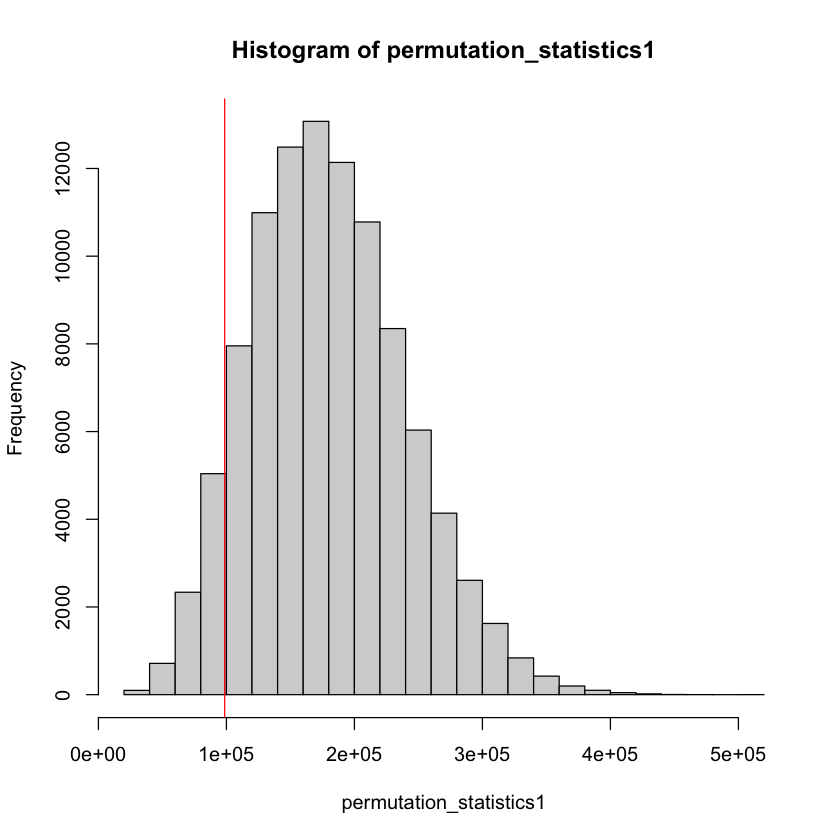

In [27]:
par(bg = 'white')
hist(permutated_statistic_exports_col)
abline(v=observed_statistic_exports_col, col='red')

In [28]:
mean(permutated_statistic_exports_col < observed_statistic_exports_col)

[1] 0.07729

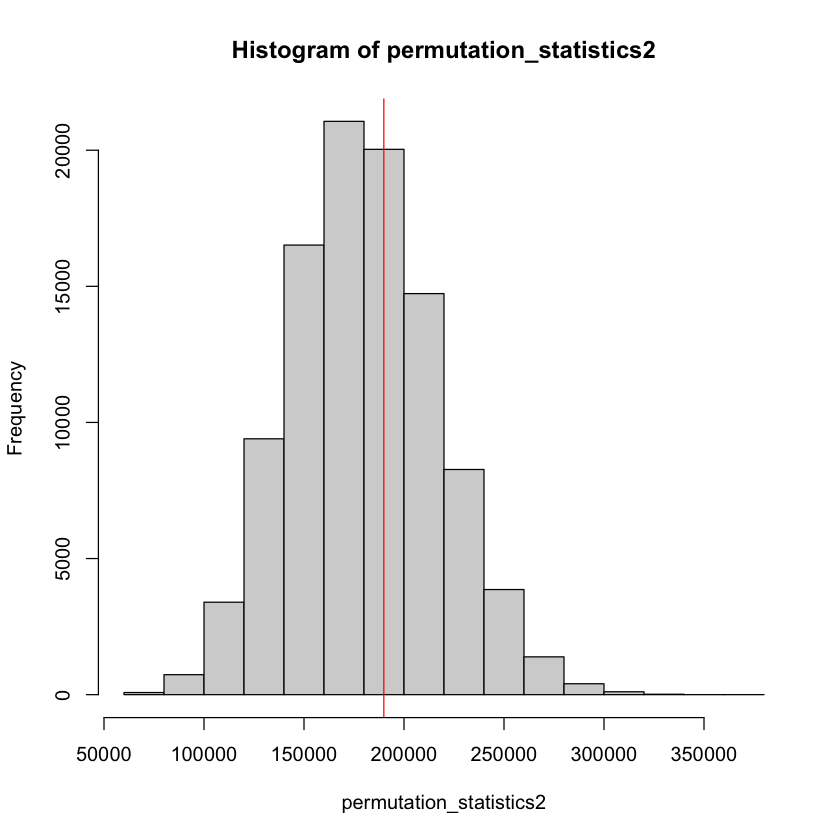

In [29]:
par(bg = 'white')
hist(permutated_statistic_imports_col)
abline(v=observed_statistic_imports_col, col='red')

In [30]:
mean(permutated_statistic_imports_col < observed_statistic_imports_col)

[1] 0.61563

### Examining the effect of GDP (both the reporter and the partner)

### Examining the effect of homophily on the network of trades

In [110]:
count_homophily = function(edges, nodes, attrs, ...) {
    count = 0
    for (i in 1:dim(edges)[1]) {
        if (attrs[nodes$country_iso3 == edges$source[i]] == attrs[nodes$country_iso3 == edges$target[i]]) {
            count = count + 1
        }
    }
    return(count)
}

In [170]:
execute_permutation_test = function(edges, nodes, func, attrs, attr, ...) {
    params = list(...)
    observed_statistic = func(edges, nodes, attrs, params)
    
    N = 1000
    n = dim(nodes)[1]
    
#     generating new samples by permutating the attributes
    permutated_samples = matrix(0, nrow = n, ncol = N)
    for (i in 1:N) {
        permutated_samples[, i] = sample(x = attrs, size = n, replace = F)
    }
    
#    computing the specified statistic for all the permutated networks
    permutated_statistics = matrix(0, nrow = N, ncol = 1)
    for (j in 1:N) {
        permutated_statistics[j] = func(edges, nodes, permutated_samples[, j], params)
    }
    
    
    par(bg = 'white')
    hist(
        permutated_statistics, 
        xlim=c(min(min(permutated_statistics), observed_statistic), max(max(permutated_statistics), observed_statistic)), 
        main = paste('Comparison of the observed statistic and \npermutated ones with respect to ', attr)
    )
    abline(v=observed_statistic, col='red')
    p_value = mean(permutated_statistics < observed_statistic)
#     print(sum(observed_statistic > permutated_statistics))
    if (p_value > .5) {
        print(1 - p_value)
    } else {
        print(p_value)
    }
    
}

[1] 0.003


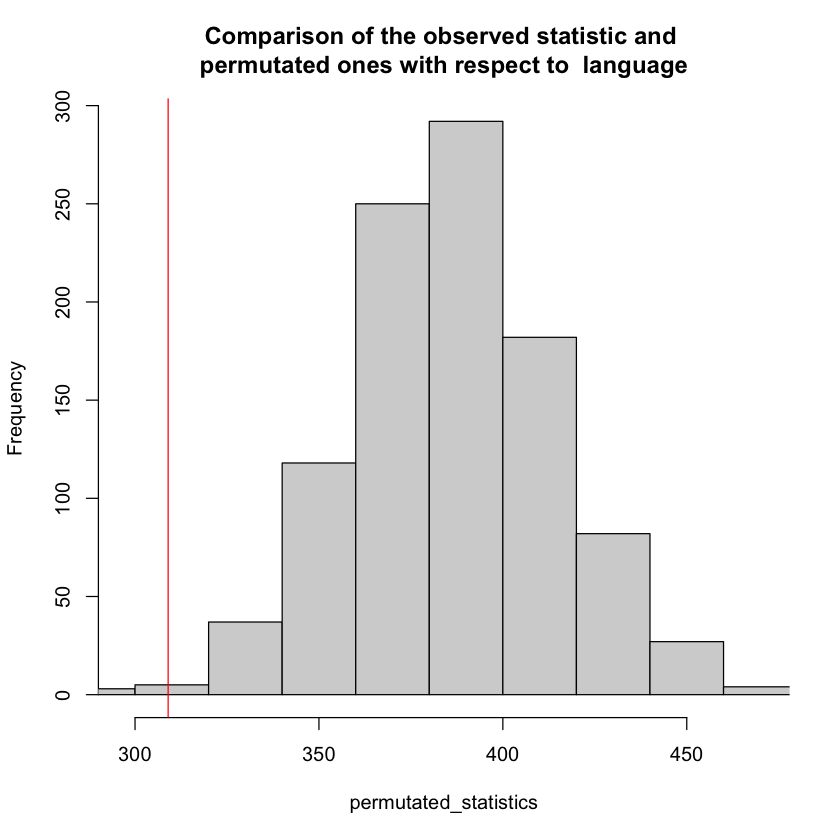

In [171]:
execute_permutation_test(edges, nodes, count_homophily, nodes$langoff_1, 'language')

[1] 0


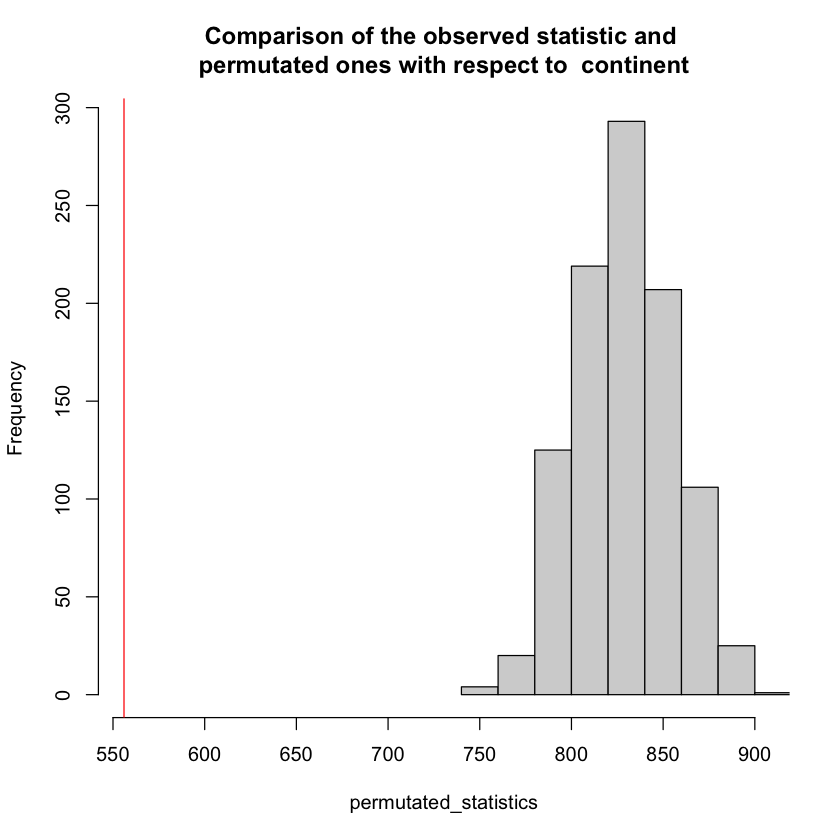

In [158]:
execute_permutation_test(edges, nodes, count_homophily, nodes$continent, 'continent')

[1] 0.374


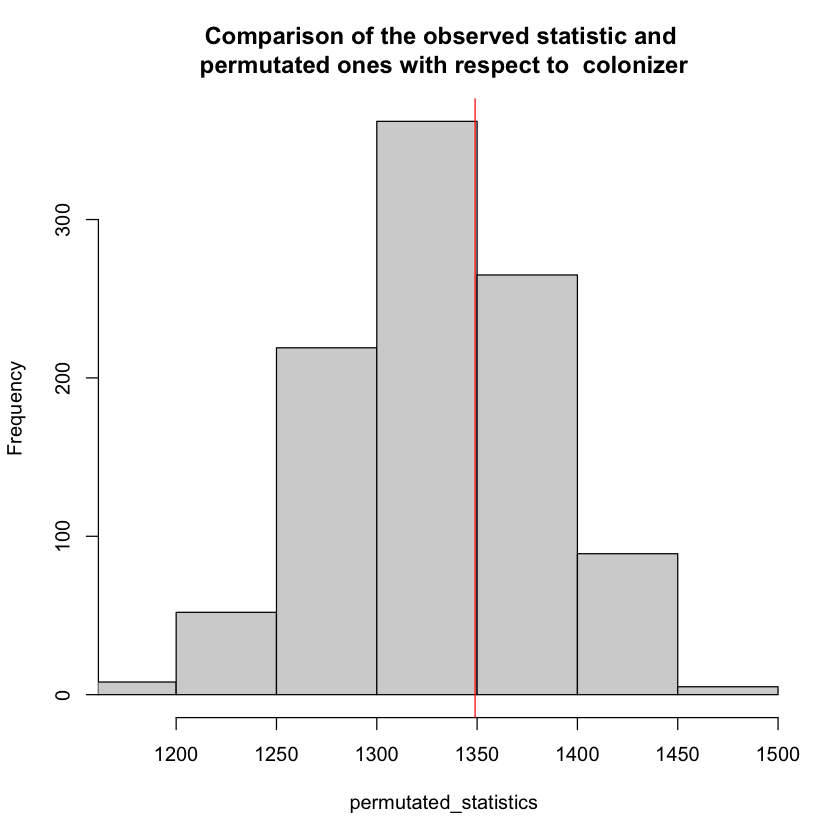

In [159]:
execute_permutation_test(edges, nodes, count_homophily, nodes$colonizer, 'colonizer')

### Examining the effect of closeness

In [160]:
compute_nodecov = function(edges, nodes, attrs, ...) {
#     log transformation parameter
    params = list(...)
    sum = 0
    for (i in 1:dim(edges)[1]) {
        if (as.logical(params[[1]])) {
            sum = sum + log(attrs[nodes$country_iso3 == edges$source[i]] + attrs[nodes$country_iso3 == edges$target[i]])
        } else {
            sum = sum + attrs[nodes$country_iso3 == edges$source[i]] + attrs[nodes$country_iso3 == edges$target[i]]
        }
    }
    return(sum)
}

In [161]:
compute_absdiff = function(edges, nodes, attrs, ...) {
#     log transformation parameter
    params = list(...)
    diff_sum = 0
    for (i in 1:dim(edges)[1]) {
        if (as.logical(params[[1]])) {
            diff_sum = diff_sum + log(1 + abs(attrs[nodes$country_iso3 == edges$source[i]] - attrs[nodes$country_iso3 == edges$target[i]]))
        } else {
            diff_sum = diff_sum + abs(attrs[nodes$country_iso3 == edges$source[i]] - attrs[nodes$country_iso3 == edges$target[i]])
        }
    }
    return(diff_sum)
}

[1] 0.22


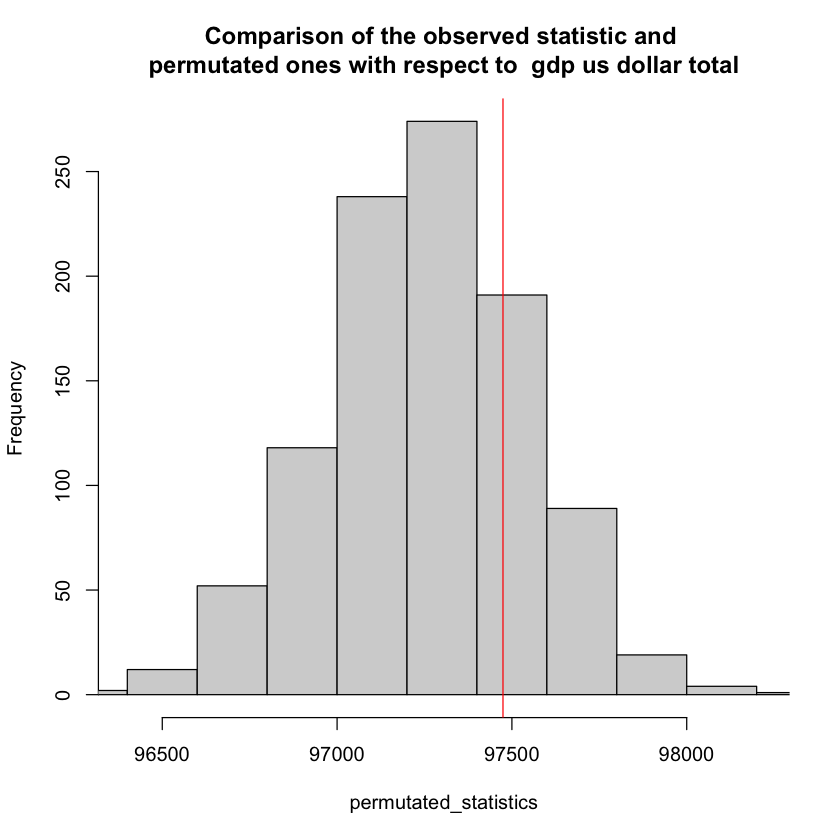

In [164]:
execute_permutation_test(edges, nodes, compute_nodecov, nodes$gdp_us_dollar, 'gdp us dollar total', TRUE)

[1] 0.12


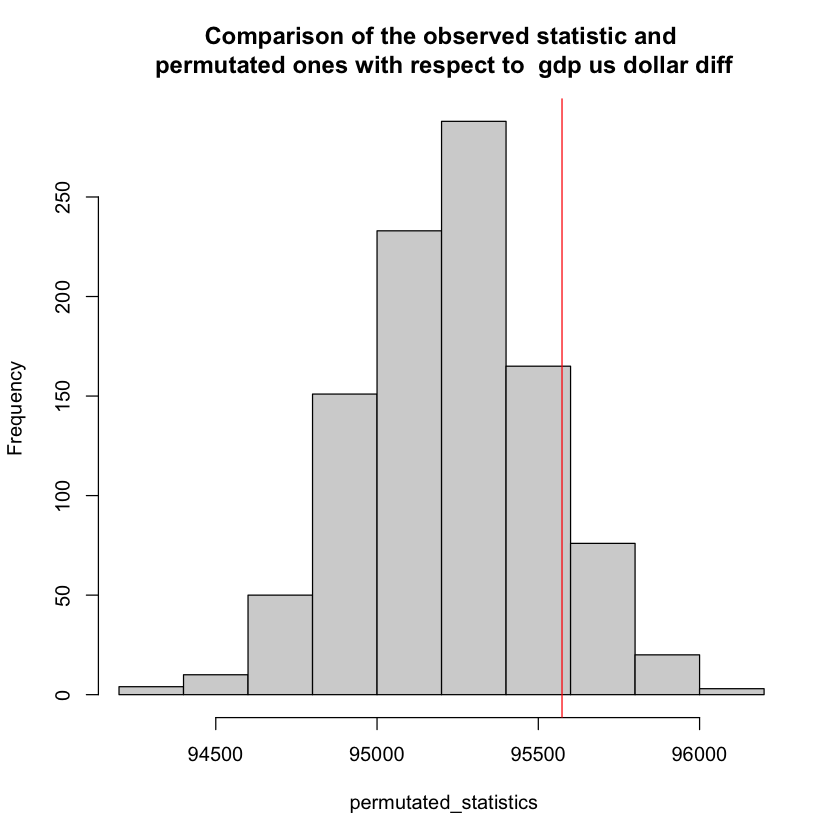

In [165]:
execute_permutation_test(edges, nodes, compute_absdiff, nodes$gdp_us_dollar, 'gdp us dollar diff', TRUE)